In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

from scipy.optimize import minimize
import scipy.stats
import sklearn.mixture as sm

# import myutils
from pyia import GaiaData

In [5]:
plt.style.use('notebook')

In [6]:
R = np.load('../data/jhelum_rotmat_init.npy')

In [7]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [8]:
t = Table(fits.getdata('../data/jhelum_des.fits'))

In [9]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [10]:
iso = Table.read('../data/mist_12.0_-1.50.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

In [11]:
# distance modulus
distance_app = 12.8*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['DECam_g']-iso['DECam_i'] + 0.05
i_g = iso['DECam_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.55*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>19)
poly_main = poly[ind]

In [12]:
wangle = 180*u.deg

In [13]:
def jhelum_dist(phi1, d0=12.8, d1=0, d2=0):
    p1, p2 = 0, 20
    if (d1==0) | (d2==0):
        d1, d2 = d0, d0
    m = (d2-d1) / (p1-p2)
    return (m*phi1.wrap_at(wangle).value + d1) * u.kpc

In [14]:
# adopt 13kpc
d0 = 13.2

# # adopt model preferred gradient
# d1 = 13
# d2 = 11

cj = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d0=d0),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [15]:
phi2_mask = (cj.phi2<1*u.deg) & (cj.phi2>0*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)
phi2off_mask = (cj.phi2<-3*u.deg) & (cj.phi2>-4*u.deg) & (cj.phi1>0*u.deg) & (cj.phi1<25*u.deg)

points = np.array([g.g0 - g.i0, g.g0]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -8*u.mas/u.yr
pm1_max = -4*u.mas/u.yr
pm2_min = -2*u.mas/u.yr
pm2_max = 2.*u.mas/u.yr
pm_mask = ((cj.pm_phi1_cosphi2 < pm1_max) & (cj.pm_phi1_cosphi2 > pm1_min) & 
           (cj.pm_phi2 < pm2_max) & (cj.pm_phi2 > pm2_min))

bhb_gi_min = -0.7
bhb_gi_max = -0.2
bhb_g_min = 15.5
bhb_g_max = 16.5
bhb_mask = (g.g0-g.i0<bhb_gi_max) & (g.g0-g.i0>bhb_gi_min) & (g.g0<bhb_g_max) & (g.g0>bhb_g_min)

poly_bs = np.array([[0.2,18.9], [0.2, 19.9], [-0.25, 18.7], [-0.25,17.7]])
path_bs = mpl.path.Path(poly_bs)
bs_mask = path_bs.contains_points(points)

In [16]:
np.sum(cmd_mask & pm_mask)

6484

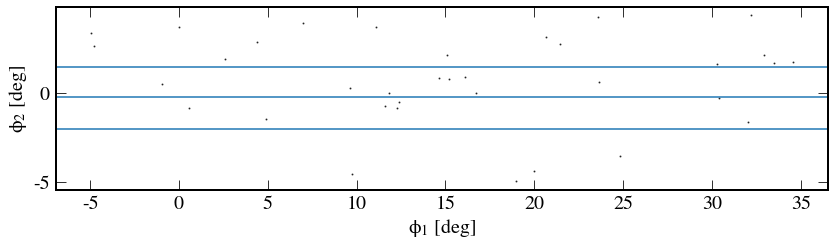

In [17]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1[pm_mask & bhb_mask].wrap_at(wangle), cj.phi2[pm_mask & bhb_mask], 'k.', ms=2, alpha=0.7)
plt.gca().set_aspect('equal')

plt.axhline(1.5)
plt.axhline(-0.2)
plt.axhline(-2)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()
plt.savefig('../plots/bhb_sky.png')

In [18]:
tout = Table(np.array([g.source_id, g.ra, g.dec, g.g, g.g0, g.i, g.i0]).T, 
             names=('source_id', 'ra', 'dec', 'g', 'g0', 'i', 'i0'))

In [19]:
tbhb = tout[pm_mask & bhb_mask]

In [20]:
tbhb.write('../data/bhb.fits', overwrite=True)

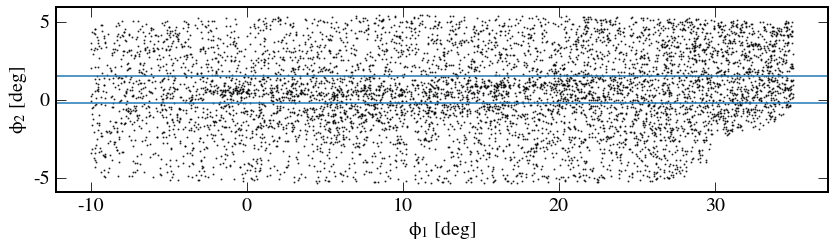

In [21]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=2, alpha=0.7)
plt.gca().set_aspect('equal')

plt.axhline(1.5)
plt.axhline(-0.2)
# plt.axhline(-2)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

### Define narrow and wide tracks

In [22]:
def mad_std(x):
    """Median absolute deviation"""
    return 1.5 * np.median(np.abs(np.median(x)-x))

In [23]:
# setup bins for finding track
bin_size = 3 # deg
bins = np.arange(-5, 25+bin_size, bin_size)
bincen = 0.5 * (bins[1:] + bins[:-1])

In [24]:
# median track
stream_mask = pm_mask & cmd_mask
phi2_wide_mask = stream_mask & (cj.phi2 < 1.5*u.deg) & (cj.phi2 > -0.1*u.deg)

phi2_median, be, bn = scipy.stats.binned_statistic((cj.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                                       cj.phi2[phi2_wide_mask].degree, 
                                       statistic='median', bins=bins)
phi2_sum, be = np.histogram((cj.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                            bins=bins)
phi2_median_err = np.abs(phi2_median) / np.sqrt(phi2_sum)

deg = 2
ptrack = np.polyfit(bincen, phi2_median, deg, w=1 / np.sqrt(phi2_sum))

polytrack = np.poly1d(ptrack)
phi1_ = np.linspace(-5, 25, 100)
phi2_ = polytrack(phi1_)

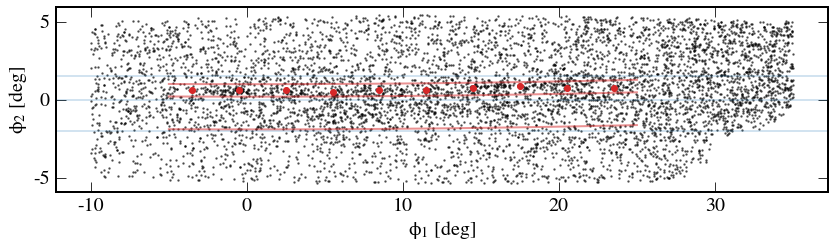

In [25]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=3, alpha=0.5)
plt.plot(bincen, phi2_median, 'o', color='tab:red')

plt.plot(phi1_, phi2_+0.4, '-', color='tab:red', lw=2, alpha=0.5)
plt.plot(phi1_, phi2_-0.4, '-', color='tab:red', lw=2, alpha=0.5)
plt.plot(phi1_, phi2_-2.5, '-', color='tab:red', lw=2, alpha=0.5)

plt.axhline(1.5, color='tab:blue', lw=2, alpha=0.2)
plt.axhline(0, color='tab:blue', lw=2, alpha=0.2)
plt.axhline(-2, color='tab:blue', lw=2, alpha=0.2)

plt.gca().set_aspect('equal')
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

In [26]:
phi1_mask = (cj.phi1.wrap_at(wangle)>-5*u.deg) & (cj.phi1.wrap_at(wangle)<25*u.deg)
narrow_mask = phi1_mask & (np.abs(cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg)<=0.4*u.deg)
wide_mask = (phi1_mask & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg<-0.4*u.deg)
             & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg>-2.*u.deg))

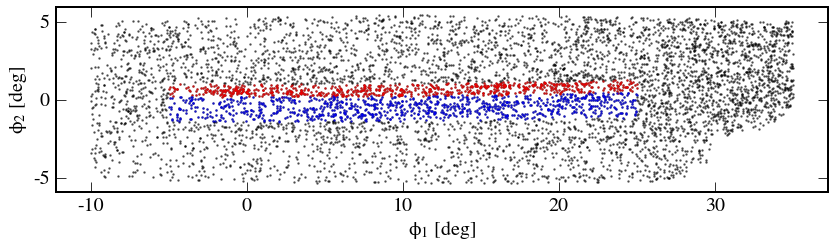

In [27]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=3, alpha=0.5)
plt.plot(cj.phi1[pm_mask & cmd_mask & narrow_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask & narrow_mask], 
         'r.', ms=3, alpha=0.5)
plt.plot(cj.phi1[pm_mask & cmd_mask & wide_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask & wide_mask], 
         'b.', ms=3, alpha=0.5)

plt.gca().set_aspect('equal')
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

## Proper motions

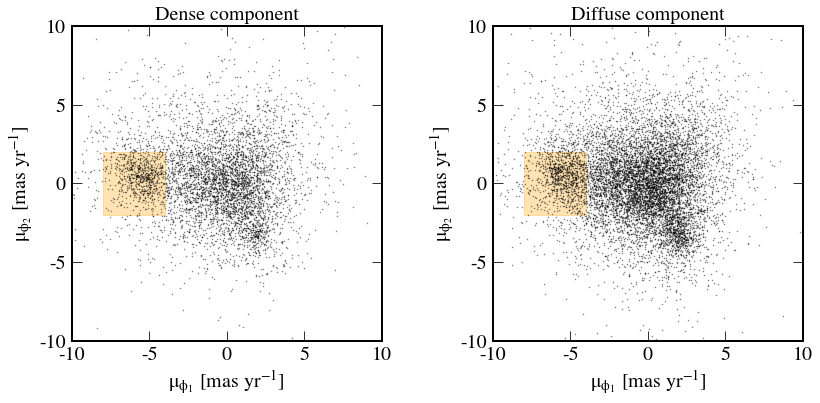

In [28]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
plt.sca(ax[0])
plt.plot(cj.pm_phi1_cosphi2[narrow_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[narrow_mask & cmd_mask].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.5, rasterized=True)

rect_xy = [pm1_min.to(u.mas/u.yr).value, pm2_min.to(u.mas/u.yr).value]
rect_w = pm1_max.to(u.mas/u.yr).value - pm1_min.to(u.mas/u.yr).value
rect_h = pm2_max.to(u.mas/u.yr).value - pm2_min.to(u.mas/u.yr).value
pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Dense component', fontsize='medium')

plt.sca(ax[1])
plt.plot(cj.pm_phi1_cosphi2[wide_mask & cmd_mask].to(u.mas/u.yr), 
         cj.pm_phi2[wide_mask & cmd_mask].to(u.mas/u.yr), 
         'ko', ms=0.5, alpha=0.5, rasterized=True)

pr = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='orange', alpha=0.3)
plt.gca().add_artist(pr)

plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
plt.title('Diffuse component', fontsize='medium')

plt.tight_layout()

In [29]:
# set up running median bins, arrays
bin_size = 3 # deg
bin_width = 4
bin_l = np.arange(-5, (25-bin_size)+1, bin_size)
bin_r = bin_l + bin_width
bins_phi1 = 0.5 * (bin_l+bin_r)

all_mask = np.ones_like(narrow_mask, dtype=bool)
masks = [all_mask, narrow_mask, wide_mask]

Nbins = len(bin_l)
rmed_n = np.zeros((3,Nbins))
rmed_phi2 = np.zeros((3,Nbins))*u.deg
rmed_phi2_err = np.zeros((3,Nbins))*u.deg
rmed_pmphi1 = np.zeros((3,Nbins))*u.mas/u.yr
rmed_pmphi2 = np.zeros((3,Nbins))*u.mas/u.yr
rmed_pmphi1_err = np.zeros((3,Nbins))*u.mas/u.yr
rmed_pmphi2_err = np.zeros((3,Nbins))*u.mas/u.yr

In [30]:
# stream track properties
phi2_poly = polytrack(cj.phi1.wrap_at(180*u.deg))
off_phi2 = 3
delta_phi2 = 1.5
_phi1 = cj.phi1.wrap_at(180*u.deg).degree

for e in range(3):
    for i, l, r in zip(range(Nbins), bin_l, bin_r):
        sel_bin = (_phi1 > l) & (_phi1 <= r)
        sel_stream = (np.abs(cj.phi2.to(u.deg).value - phi2_poly) < delta_phi2)
#         sel_stream = (np.abs(cj.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly) < delta_phi2)
#         sel_back = ((np.abs(cj.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly - off_phi2)<delta_phi2) |
#                     (np.abs(cj.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly + off_phi2)<delta_phi2))
        selection = sel_bin & sel_stream & masks[e] & pm_mask & cmd_mask
        rmed_n[e][i] = np.sum(selection)

        rmed_phi2[e][i] = np.nanmedian(cj.phi2[selection])
        rmed_phi2_err[e][i] = mad_std(cj.phi2[selection])

        rmed_pmphi1[e][i] = np.nanmedian(cj_dist.pm_phi1_cosphi2[selection])
        rmed_pmphi1_err[e][i] = mad_std(cj_dist.pm_phi1_cosphi2[selection])

        rmed_pmphi2[e][i] = np.nanmedian(cj_dist.pm_phi2[selection])
        rmed_pmphi2_err[e][i] = mad_std(cj_dist.pm_phi2[selection])

In [31]:
import gala.dynamics as gd
import gala.potential as gp

ham = gp.Hamiltonian(gp.MilkyWayPotential(nucleus=dict(m=0), 
                                          halo=dict(c=0.95, m=7E11),
                                          bulge=dict(m=4E9),
                                          disk=dict(m=5.5e10)))
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)

pos = np.load('../data/jhelum_orbit_narrow.npy')
# pos = np.load('../data/jhelum_orbit.npy')

phi1, phi2, d, pm1, pm2, vr = pos

c_ = Jhelum(phi1=phi1*u.deg, phi2=phi2*u.deg, distance=d*u.kpc, 
           pm_phi1_cosphi2=pm1*u.mas/u.yr,
           pm_phi2=pm2*u.mas/u.yr,
           radial_velocity=vr*u.km/u.s)
w0 = gd.PhaseSpacePosition(c_.transform_to(gc_frame).cartesian)

dt = 0.5*u.Myr
fit_orbit = ham.integrate_orbit(w0, dt=dt, n_steps=42)
model_jhelum_nocorr = fit_orbit.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)

In [32]:
# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = model_jhelum_nocorr.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
model_jhelum = coord.Galactic(rep).transform_to(Jhelum)

In [33]:
rmed_n_ = rmed_n - np.min(rmed_n, axis=1)[:,np.newaxis]
rmed_norm = rmed_n_ / np.max(rmed_n_, axis=1)[:,np.newaxis]
print(rmed_norm)

[[0.         0.5        0.46666667 0.66666667 0.48333333 0.46666667
  0.80833333 0.55       1.         0.575     ]
 [0.35       1.         0.56666667 0.71666667 0.83333333 0.4
  0.98333333 0.9        0.61666667 0.        ]
 [0.         0.20754717 0.22641509 0.58490566 0.52830189 0.75471698
  0.86792453 0.33962264 1.         0.28301887]]


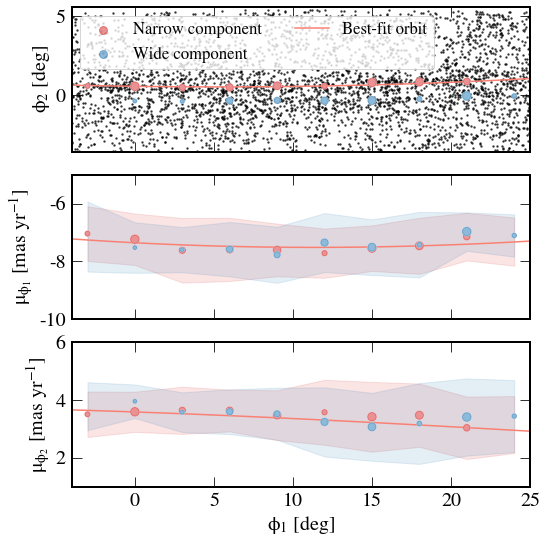

In [34]:
fig, ax = plt.subplots(3,1,figsize=(8,8), sharex=True, subplot_kw={'adjustable':'datalim'})

cmaps = ['OrRd', 'GnBu']
colors = ['tab:red', 'tab:blue', 'salmon']
meds = [rmed_phi2, rmed_pmphi1, rmed_pmphi2]
errs = [rmed_phi2_err, rmed_pmphi1_err, rmed_pmphi2_err]
labels = ['Narrow component', 'Wide component']

for e in range(2):
    for k in range(3):
        plt.sca(ax[k])
#         plt.errorbar(bins_phi1, meds[k][e+1].value, yerr=errs[k][e+1].value, fmt='none',
#                      color=colors[e], alpha=0.5, lw=3, label='', zorder=0)
#         plt.plot(bins_phi1, meds[k][e+1], 'wo', ms=8, label='')
#         plt.plot(bins_phi1, meds[k][e+1], 'o', ms=8, color=colors[e], alpha=0.5, label=labels[e])
#         plt.scatter(bins_phi1, meds[k][e+1], c=rmed_norm[e+1], cmap=cmaps[e], vmin=0, vmax=1)
        if k>0:
            plt.fill_between(bins_phi1, meds[k][e+1] - errs[k][e+1], meds[k][e+1] + errs[k][e+1],
                            color=colors[e], alpha=0.12, label='', zorder=0)
        
        plt.scatter(bins_phi1, meds[k][e+1], color='w', s=(rmed_norm[e+1]*75)**1, alpha=1, label='',
                   zorder=10)
        plt.scatter(bins_phi1, meds[k][e+1], color=colors[e], s=(rmed_norm[e+1]*75)**1, alpha=0.5, label=labels[e],
                   zorder=10)

plt.sca(ax[0])
# plt.plot(bins_phi1, rmed_phi2[0], 'k-', alpha=0.1, lw=6, label='Whole Jhelum')
# plt.fill_between(bins_phi1, rmed_phi2[0]-rmed_phi2_err[0], rmed_phi2[0]+rmed_phi2_err[0],
#                  color='k', alpha=0.1, label='')
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=3, alpha=0.6, zorder=0,
        label='')
plt.plot(model_jhelum_nocorr.phi1.wrap_at(wangle), model_jhelum_nocorr.phi2, '-', color=colors[2],
         label='Best-fit orbit')

plt.ylabel('$\phi_2$ [deg]')
plt.ylim(-2,4)
plt.xlim(-4,25)
plt.gca().set_aspect('equal')

# plt.legend(loc=2, fontsize='small', ncol=2)
# reorder legend entries
handles, labels = plt.gca().get_legend_handles_labels()
legend_order = np.array([1,2,0], dtype=np.int)
handles = [handles[x] for x in legend_order]
labels = [labels[x] for x in legend_order]
plt.legend(handles, labels, loc=2, fontsize='small', ncol=2, markerscale=1.3)

plt.sca(ax[1])
# plt.plot(bins_phi1, rmed_pmphi1[0], 'k-', alpha=0.1, lw=6)
# plt.fill_between(bins_phi1, rmed_pmphi1[0]-rmed_pmphi1_err[0], rmed_pmphi1[0]+rmed_pmphi1_err[0],
#                  color='k', alpha=0.1)
plt.plot(model_jhelum_nocorr.phi1.wrap_at(wangle), model_jhelum_nocorr.pm_phi1_cosphi2.to(u.mas/u.yr), '-',
        color=colors[2],)

plt.ylim(-10,-5)
plt.ylabel('$\mu_{\phi_1}$ [mas yr$^{-1}$]')

plt.sca(ax[2])
# plt.plot(bins_phi1, rmed_pmphi2[0], 'k-', alpha=0.1, lw=6)
# plt.fill_between(bins_phi1, rmed_pmphi2[0]-rmed_pmphi2_err[0], rmed_pmphi2[0]+rmed_pmphi2_err[0],
#                  color='k', alpha=0.1)
plt.plot(model_jhelum_nocorr.phi1.wrap_at(wangle), model_jhelum_nocorr.pm_phi2.to(u.mas/u.yr), '-',
         color=colors[2],)

plt.ylim(1,6)
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\mu_{\phi_2}$ [mas yr$^{-1}$]')
    
plt.tight_layout(h_pad=0.3)
plt.savefig('../paper/components.pdf')

In [35]:
'Track offset: {:.1f}'.format(np.median(meds[0][1] - meds[0][2]))

'Track offset: 0.9 deg'

In [36]:
'PM offset: {:.3f}, {:.3f}'.format(np.min(np.abs(meds[1][1] - meds[1][2])), np.abs(np.max(meds[1][1] - meds[1][2])))

'PM offset: 0.009 mas / yr, 0.289 mas / yr'

In [37]:
'PM offset: {:.3f}, {:.3f}'.format(np.min(np.abs(meds[2][1] - meds[2][2])), np.abs(np.max(meds[2][1] - meds[2][2])))

'PM offset: 0.039 mas / yr, 0.348 mas / yr'

In [38]:
np.median(g.pmra_error[cmd_mask & pm_mask]), np.median(g.pmdec_error[cmd_mask & pm_mask])

(<Quantity 0.65370409 marcsec / yr>, <Quantity 0.78399913 marcsec / yr>)

In [39]:
np.min(errs[1][1]), np.max(errs[1][1]), np.min(errs[2][1]), np.max(errs[2][1])

(<Quantity 0.78867283 mas / yr>,
 <Quantity 1.11891672 mas / yr>,
 <Quantity 0.69502304 mas / yr>,
 <Quantity 1.20861288 mas / yr>)

In [40]:
np.min(errs[1][2]), np.max(errs[1][2]), np.min(errs[2][2]), np.max(errs[2][2])

(<Quantity 0.66649265 mas / yr>,
 <Quantity 1.21197671 mas / yr>,
 <Quantity 0.58213662 mas / yr>,
 <Quantity 1.39985283 mas / yr>)

## BS / BHB

In [416]:
# footprints
stream_mask = wide_mask | narrow_mask
off_mask = ((np.abs(cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg+4*u.deg)<0.6*u.deg) | 
            (np.abs(cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg-4*u.deg)<0.6*u.deg))

spatial_masks = [off_mask, stream_mask, narrow_mask, wide_mask]
mask_labels = ['control', 'stream', 'narrow', 'wide']
farea = np.array([1,1,1/3,2/3])

In [417]:
stream_bhb2bs = (np.nansum((wide_mask | narrow_mask) & pm_mask & bhb_mask)/
                 np.nansum((wide_mask | narrow_mask) & pm_mask & bs_mask))
stream_bhb2bs_err = (np.sqrt(np.nansum((wide_mask | narrow_mask) & pm_mask & bhb_mask))/
                     np.nansum((wide_mask | narrow_mask) & pm_mask & bs_mask))
nbhb = []
ebhb = []
nbs = []
ebs = []

for mask in spatial_masks: 
    nbhb_ = np.nansum(mask & pm_mask & bhb_mask)
    ebhb_ = np.sqrt(nbhb_)
    nbhb += [nbhb_]
    ebhb += [ebhb_]
    
    nbs_ = np.nansum(mask & pm_mask & bs_mask)
    ebs_ = np.sqrt(nbs_)
    nbs += [nbs_]
    ebs += [ebs_]

nbhb = np.array(nbhb)
ebhb = np.array(ebhb)
nbs = np.array(nbs)
ebs = np.array(ebs)

In [418]:
for e,m in enumerate(spatial_masks):
    print('{}: $N_{{BHB}}$ = {}, $N_{{BS}}$ = {}'.format(mask_labels[e], nbhb[e], nbs[e]))

control: $N_{BHB}$ = 2, $N_{BS}$ = 12
stream: $N_{BHB}$ = 12, $N_{BS}$ = 31
narrow: $N_{BHB}$ = 6, $N_{BS}$ = 13
wide: $N_{BHB}$ = 6, $N_{BS}$ = 18


In [419]:
# contamination free BS/BHB ratio
nbhb_corr = nbhb - nbhb[0]*farea
ebhb_corr = np.sqrt(nbhb_corr)
nbs_corr = nbs - nbs[0]*farea
ebs_corr = np.sqrt(nbs_corr)

In [420]:
# BS / BHB ratio
bs2bhb = nbs / nbhb
ebs2bhb = np.sqrt((ebs/nbhb)**2 + (nbs*ebhb/nbhb**2)**2)

# accounting for contamination
bs2bhb_corr = nbs_corr / nbhb_corr
ebs2bhb_corr = np.sqrt((ebs_corr/nbhb_corr)**2 + (nbs_corr*ebhb_corr/nbhb_corr**2)**2)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [421]:
print('contamination subtracted')
for e in range(len(spatial_masks)):
    print('{}: BS / BHB = {:.1f} +- {:.1f}'.format(mask_labels[e], bs2bhb_corr[e], ebs2bhb_corr[e]))

contamination subtracted
control: BS / BHB = nan +- nan
stream: BS / BHB = 1.9 +- 0.7
narrow: BS / BHB = 1.7 +- 0.9
wide: BS / BHB = 2.1 +- 1.2


In [422]:
print('raw counts')
for e in range(len(spatial_masks)):
    print('{}: BS / BHB = {:.1f} +- {:.1f}'.format(mask_labels[e], bs2bhb[e], ebs2bhb[e]))

raw counts
control: BS / BHB = 6.0 +- 4.6
stream: BS / BHB = 2.6 +- 0.9
narrow: BS / BHB = 2.2 +- 1.1
wide: BS / BHB = 3.0 +- 1.4


### Compare populations in narrow vs wide track

In [227]:
wide_masks = []

for pmax in np.arange(-0.4,-1.2,-0.05):
    wide_masks += [(phi1_mask & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg<pmax*u.deg)
                    & (cj.phi2 - polytrack(cj.phi1.wrap_at(wangle).deg)*u.deg>=(pmax-0.8)*u.deg))]

Nwide = len(wide_masks)

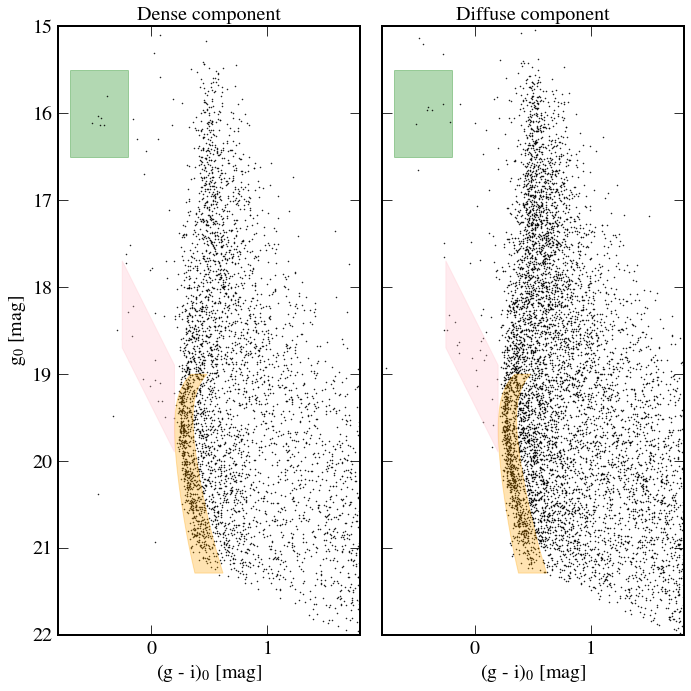

In [228]:
fig, ax = plt.subplots(1,2,figsize=(10,10), sharey=True, sharex=True)
plt.sca(ax[0])
plt.plot(g.g0[narrow_mask & pm_mask] - g.i0[narrow_mask & pm_mask], g.g0[narrow_mask & pm_mask], 
         'ko', ms=0.5, alpha=1, rasterized=True, label='')

# plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

pbs = mpl.patches.Polygon(poly_bs, color='pink', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pbs)

rect_xy = [bhb_gi_min, bhb_g_min]
rect_w = bhb_gi_max - bhb_gi_min
rect_h = bhb_g_max - bhb_g_min
pr_bhb = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='green', alpha=0.3)
plt.gca().add_artist(pr_bhb)

plt.xlim(-0.8,1.8)
plt.ylim(22, 15)
plt.xlabel('(g - i)$_0$ [mag]')
plt.ylabel('g$_0$ [mag]')
plt.title('Dense component', fontsize='medium')

plt.sca(ax[1])
plt.plot(g.g0[wide_mask & pm_mask] - g.i0[wide_mask & pm_mask], g.g0[wide_mask & pm_mask], 
         'ko', ms=0.5, alpha=1, rasterized=True, label='')

# plt.plot(i_gi, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pm)

pbs = mpl.patches.Polygon(poly_bs, color='pink', alpha=0.3, zorder=2, label='')
plt.gca().add_artist(pbs)

pr_bhb = mpl.patches.Rectangle(rect_xy, rect_w, rect_h, color='green', alpha=0.3)
plt.gca().add_artist(pr_bhb)

plt.xlim(-0.8,1.8)
plt.ylim(22, 15)
plt.xlabel('(g - i)$_0$ [mag]')
plt.title('Diffuse component', fontsize='medium')

plt.tight_layout()

In [229]:
bright_mask = g.g0<19.5

In [230]:
wide_bhb2ms = np.empty(Nwide)
wide_bs2ms = np.empty(Nwide)
wide_bhb2bs = np.empty(Nwide)

for e in range(Nwide):
    wide_bhb2ms[e] = (np.nansum(wide_masks[e] & pm_mask & bhb_mask)/np.nansum(wide_masks[e] & pm_mask & cmd_mask
                                                                              & bright_mask))
    wide_bs2ms[e] = (np.nansum(wide_masks[e] & pm_mask & bs_mask)/np.nansum(wide_masks[e] & pm_mask & cmd_mask
                                                                            & bright_mask))
    wide_bhb2bs[e] = (np.nansum(wide_masks[e] & pm_mask & bhb_mask)/np.nansum(wide_masks[e] & pm_mask & bs_mask))

In [240]:
# narrow component
narrow_bhb2ms = (np.nansum(narrow_mask & pm_mask & bhb_mask)/np.nansum(narrow_mask & pm_mask & cmd_mask 
                                                                       & bright_mask))
narrow_bs2ms = (np.nansum(narrow_mask & pm_mask & bs_mask)/np.nansum(narrow_mask & pm_mask & cmd_mask 
                                                                     & bright_mask))
narrow_bhb2bs = (np.nansum(narrow_mask & pm_mask & bhb_mask)/np.nansum(narrow_mask & pm_mask & bs_mask))

# whole wide component
wideall_bhb2ms = (np.nansum(wide_mask & pm_mask & bhb_mask)/np.nansum(wide_mask & pm_mask & cmd_mask 
                                                                      & bright_mask))
wideall_bs2ms = (np.nansum(wide_mask & pm_mask & bs_mask)/np.nansum(wide_mask & pm_mask & cmd_mask 
                                                                    & bright_mask))
wideall_bhb2bs = (np.nansum(wide_mask & pm_mask & bhb_mask)/np.nansum(wide_mask & pm_mask & bs_mask))

# whole stream
stream_bhb2ms = (np.nansum((wide_mask | narrow_mask) & pm_mask & bhb_mask)/
                 np.nansum((wide_mask | narrow_mask) & pm_mask & cmd_mask & bright_mask))
stream_bs2ms = (np.nansum((wide_mask | narrow_mask) & pm_mask & bs_mask)/
                np.nansum((wide_mask | narrow_mask) & pm_mask & cmd_mask & bright_mask))
stream_bhb2bs = (np.nansum((wide_mask | narrow_mask) & pm_mask & bhb_mask)/
                 np.nansum((wide_mask | narrow_mask) & pm_mask & bs_mask))
stream_bhb2bs_err = (np.sqrt(np.nansum((wide_mask | narrow_mask) & pm_mask & bhb_mask))/
                     np.nansum((wide_mask | narrow_mask) & pm_mask & bs_mask))

In [244]:
print((np.nansum((wide_mask | narrow_mask) & pm_mask & bhb_mask)),
       (np.nansum((wide_mask | narrow_mask) & pm_mask & bs_mask)))

12 31


In [245]:
12/31

0.3870967741935484

In [241]:
print(stream_bhb2bs, stream_bhb2bs_err)

0.3870967741935484 0.11174521339154046


In [232]:
print('bhb2ms narrow/wide', narrow_bhb2ms/wideall_bhb2ms)
print('bs2ms narrow/wide', narrow_bs2ms/wideall_bs2ms)

bhb2ms narrow/wide 1.2774193548387096
bs2ms narrow/wide 0.9225806451612903


In [233]:
narrow_bhb2ms_err = (np.sqrt(np.nansum(narrow_mask & pm_mask & bhb_mask))/np.nansum(narrow_mask & pm_mask & cmd_mask 
                                                                       & bright_mask))
wideall_bhb2ms_err = (np.sqrt(np.nansum(wide_mask & pm_mask & bhb_mask))/np.nansum(wide_mask & pm_mask & cmd_mask 
                                                                       & bright_mask))

narrow_bs2ms_err = (np.sqrt(np.nansum(narrow_mask & pm_mask & bs_mask))/np.nansum(narrow_mask & pm_mask & cmd_mask 
                                                                       & bright_mask))
wideall_bs2ms_err = (np.sqrt(np.nansum(wide_mask & pm_mask & bs_mask))/np.nansum(wide_mask & pm_mask & cmd_mask 
                                                                       & bright_mask))

narrow_bhb2bs_err = (np.sqrt(np.nansum(narrow_mask & pm_mask & bhb_mask))/np.nansum(narrow_mask & pm_mask & bs_mask))
wideall_bhb2bs_err = (np.sqrt(np.nansum(wide_mask & pm_mask & bhb_mask))/np.nansum(wide_mask & pm_mask & bs_mask))

In [234]:
print('narrow bhb2ms {:.2g} +- {:.2g}'.format(narrow_bhb2ms, narrow_bhb2ms_err))
print('wide bhb2ms {:.2g} +- {:.2g}'.format(wideall_bhb2ms, wideall_bhb2ms_err))

narrow bhb2ms 0.039 +- 0.016
wide bhb2ms 0.03 +- 0.012


In [235]:
print('narrow bs2ms {:.2g} +- {:.2g}'.format(narrow_bs2ms, narrow_bs2ms_err))
print('wide bs2ms {:.2g} +- {:.2g}'.format(wideall_bs2ms, wideall_bs2ms_err))

narrow bs2ms 0.084 +- 0.023
wide bs2ms 0.091 +- 0.021


In [236]:
print('narrow bhb2bs {:.2g} +- {:.2g}'.format(narrow_bhb2bs, narrow_bhb2bs_err))
print('wide bhb2bs {:.2g} +- {:.2g}'.format(wideall_bhb2bs, wideall_bhb2bs_err))

narrow bhb2bs 0.46 +- 0.19
wide bhb2bs 0.33 +- 0.14


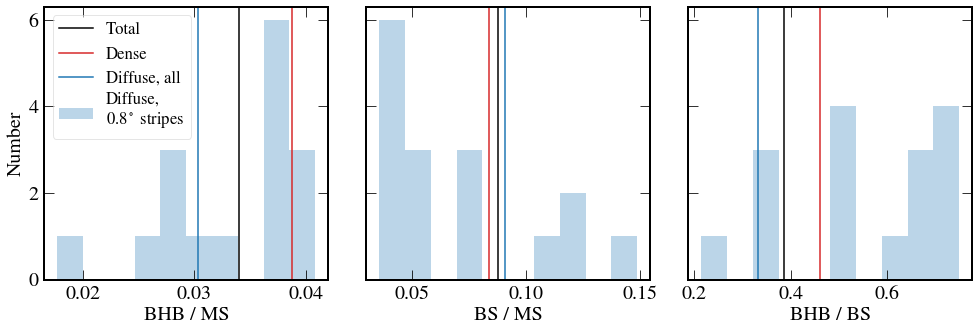

In [237]:
fig, ax = plt.subplots(1,3,figsize=(14,5), sharey=True)

plt.sca(ax[0])
plt.hist(wide_bhb2ms, alpha=0.3, label='Diffuse,\n0.8$^\circ$ stripes')
plt.axvline(stream_bhb2ms, color='k', label='Total')
plt.axvline(narrow_bhb2ms, color='tab:red', label='Dense')
plt.axvline(wideall_bhb2ms, label='Diffuse, all')

# plt.xlim(0,0.05)
plt.legend(fontsize='small', framealpha=0.5)
plt.ylabel('Number')
plt.xlabel('BHB / MS')

plt.sca(ax[1])
plt.hist(wide_bs2ms, alpha=0.3)
plt.axvline(narrow_bs2ms, color='tab:red')
plt.axvline(wideall_bs2ms)
plt.axvline(stream_bs2ms, color='k')

# plt.xlim(0,0.2)
plt.xlabel('BS / MS')

plt.sca(ax[2])
plt.hist(wide_bhb2bs, alpha=0.3)
plt.axvline(narrow_bhb2bs, color='tab:red')
plt.axvline(wideall_bhb2bs)
plt.axvline(stream_bhb2bs, color='k')

# plt.xlim(0,0.2)
plt.xlabel('BHB / BS')

plt.tight_layout()

### Brutus distances

In [33]:
tb = Table.read('../data/brutus_distances.fits')

In [34]:
tb_narrow_mask = narrow_mask[cmd_mask & pm_mask]
tb_wide_mask = wide_mask[cmd_mask & pm_mask]
tb_control_mask = ~tb_narrow_mask & ~tb_wide_mask & phi1_mask[cmd_mask & pm_mask]

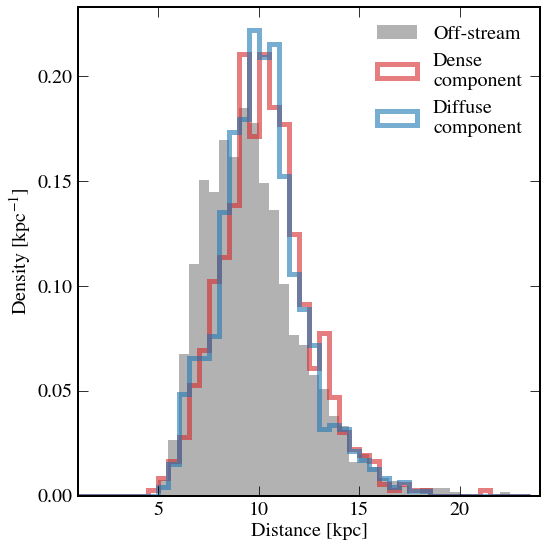

In [35]:
dbins = np.arange(1,24,0.5)

# plt.hist(tb['distance'], bins=dbins, histtype='step', color='k', normed=True, alpha=0.2)
plt.hist(tb['distance'][tb_control_mask], bins=dbins, histtype='stepfilled', color='k', alpha=0.3, normed=True,
        label='Off-stream')
plt.hist(tb['distance'][tb_narrow_mask], bins=dbins, histtype='step', color='tab:red', normed=True, lw=5, alpha=0.6,
        label='Dense\ncomponent')
plt.hist(tb['distance'][tb_wide_mask], bins=dbins, histtype='step', color='tab:blue', normed=True, lw=5, alpha=0.6,
        label='Diffuse\ncomponent')

plt.legend(frameon=False)
plt.xlabel('Distance [kpc]')
plt.ylabel('Density [kpc$^{-1}$]')
plt.xlim(1,24)

plt.tight_layout()
plt.savefig('../plots/jhelum_components_distances.png', dpi=150)

In [36]:
for mask in [tb_narrow_mask, tb_wide_mask, tb_control_mask]:
    print(np.percentile(tb['distance'][mask], [16,50,84]))

[ 8.1782726  10.19856739 12.35405034]
[ 8.16583739 10.03694123 12.09376634]
[ 7.4091538   9.44470595 12.09266133]


In [37]:
tb.colnames

['distance',
 'distance_edn',
 'distance_eup',
 'parallax',
 'parallax_edn',
 'parallax_eup']

## KICP plots

In [38]:
plt.style.use('si_white_dosis')

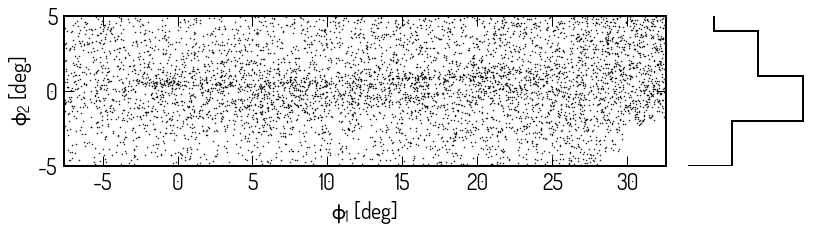

In [39]:
fig, ax = plt.subplots(1,2,figsize=(12,3.7), gridspec_kw = {'width_ratios':[5,1]}, sharey='row')
plt.sca(ax[0])
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=1, alpha=1)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')
plt.ylim(-5,5)

plt.sca(ax[1])
plt.hist(cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value, 
                                  bins=bins, histtype='step', lw=2, normed=True, color='k', orientation='horizontal')
plt.axis('off')
plt.tight_layout(w_pad=0.)
plt.savefig('../plots/jhelum_map_hist.png', dpi=150)

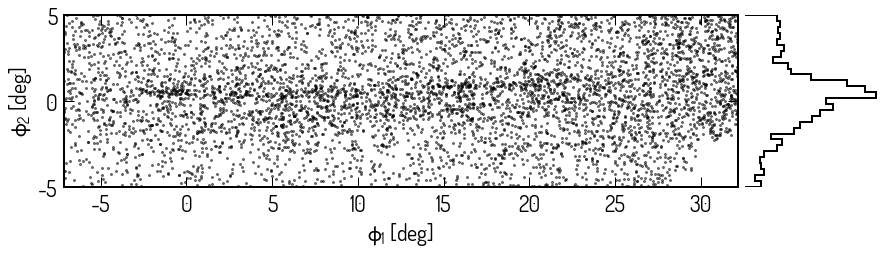

In [40]:
fig, ax = plt.subplots(1,2,figsize=(13,4), gridspec_kw = {'width_ratios':[5,1]}, sharey='row')
plt.sca(ax[0])
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=4, alpha=0.5)

plt.ylim(-5,5)
plt.gca().set_aspect('equal')

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.sca(ax[1])
bins = np.linspace(-5,5,30)
plt.hist(cj.phi2[pm_mask & cmd_mask & phi1_mask].to(u.deg).value, 
         bins=bins, histtype='step', lw=2, normed=True, color='k', orientation='horizontal')
plt.xlim(0.03,0.23)
plt.axis('off')
plt.tight_layout(w_pad=0.)
plt.savefig('../plots/kicp_jhelum_0.svg')

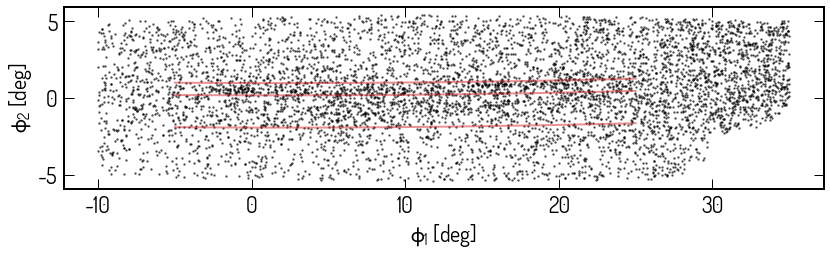

In [41]:
plt.figure(figsize=(12,10))
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), cj.phi2[pm_mask & cmd_mask], 'k.', ms=3, alpha=0.5)

plt.plot(phi1_, phi2_+0.4, '-', color='tab:red', lw=2, alpha=0.5)
plt.plot(phi1_, phi2_-0.4, '-', color='tab:red', lw=2, alpha=0.5)
plt.plot(phi1_, phi2_-2.5, '-', color='tab:red', lw=2, alpha=0.5)

plt.gca().set_aspect('equal')
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

plt.tight_layout()

In [44]:
tout = Table([g.source_id[pm_mask & cmd_mask],
              narrow_mask[cmd_mask & pm_mask],
              wide_mask[cmd_mask & pm_mask]], names=('source_id', 'dense_mask', 'diffuse_mask'))

In [47]:
np.sum(tout['dense_mask']), np.sum(tout['diffuse_mask'])

(723, 946)

In [48]:
tout.write('../data/jhelum_members.fits')